In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
!nvidia-smi

Sat May 11 07:41:22 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install keras

In [ ]:
!python -m pip install "tensorflow<2.18"

In [ ]:
!pip install keras-utils

  Preparing metadata (setup.py) ... done
  Created wheel for keras-utils: filename=keras_utils-1.0.13-py3-none-any.whl size=2631 sha256=5d538dd3a5abdb12e9a47d6ecb6e8ff97535d1871ad2b1d0f50b05b7b2bd2c2a
  Stored in directory: /root/.cache/pip/wheels/5c/c0/b3/0c332de4fd71f3733ea6d61697464b7ae4b2b5ff0300e6ca7a
Successfully built keras-utils


## Tổng quan về khối u nội sọ và tầm quan trọng của Segmentation

- Khối u não, một trong những bệnh lý ung thư nguy hiểm và phức tạp, đòi hỏi việc chẩn đoán và theo dõi chính xác qua các phương pháp hình ảnh như MRI và CT scan. Trong đó, việc áp dụng phân đoạn hình ảnh, hay segmentation, là bước thiết yếu để xác định kích thước, vị trí và ranh giới của khối u, từ đó hỗ trợ các bác sĩ trong việc lên kế hoạch điều trị và đánh giá hiệu quả liệu pháp. 

## Có hai loại khối u não chính:

- U não nguyên phát, bao gồm các khối u phát triển trực tiếp từ não hoặc các mô liên quan như u thần kinh đệm (bao gồm u tế bào hình sao, u thần kinh đệm ít gai và u màng não thất) và u lympho ở hệ thần kinh trung ương. Khối u này còn có thể phát triển từ các cấu trúc nằm ngoài dây thần kinh, như u màng não và u dây thần kinh tiền đình ốc tai.
- U não thứ phát hoặc di căn, xuất phát từ các mô ngoài não và sau đó di căn đến não.
Trong thực tế, u não di căn xuất hiện nhiều hơn đến 10 lần so với các khối u nguyên phát.


## Lý do chọn kiến trúc U-net cho việc Segmentation

- Một trong những đặc điểm nổi bật của U-Net là khả năng làm việc hiệu quả ngay cả với lượng dữ liệu huấn luyện nhỏ. Điều này rất quan trọng trong lĩnh vực y tế, nơi mà dữ liệu thường khan hiếm và việc thu thập cũng như gán nhãn dữ liệu có thể tốn kém và thời gian.

## Mục tiêu và phạm vi của báo cáo

- Báo cáo này nhằm mục tiêu khảo sát và phân tích hiệu quả của kiến trúc mạng nơ-ron tích chập U-Net trong việc phân đoạn và chẩn đoán hình ảnh y tế, đặc biệt là các khối u nội sọ từ hình ảnh chụp cộng hưởng từ (MRI). Phạm vi nghiên cứu tập trung vào việc áp dụng U-Net, một mô hình được điều chỉnh và tối ưu hóa để xử lý các thách thức đặc thù trong phân đoạn hình ảnh y tế chính xác và nhanh chóng.

In [ ]:
import zipfile
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import tensorflow
import random
import pandas as pd
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
import os
import numpy as np
from numpy import *
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from keras.callbacks import CSVLogger
import keras.backend as K
import keras
from sklearn.model_selection import train_test_split
from skimage.util import montage
from skimage.transform import rotate
import nibabel as nib
import cv2
from pathlib import Path
import matplotlib.patches as patches
from keras.utils import Sequence
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.models import Model
import tensorflow as tf

In [ ]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# GIỚI THIỆU QUA VỀ TẬP DỮ LIỆU BRATS2020

- BraTS luôn tập trung vào việc đánh giá các phương pháp tiên tiến trong việc phân đoạn khối u não dựa trên ảnh chụp cộng hưởng từ đa mô thức (MRI). Trong khuôn khổ BraTS 2020, các ảnh MRI được thu thập trước khi tiến hành phẫu thuật từ nhiều cơ sở khác nhau đã được sử dụng. Chương trình này chủ yếu tập trung vào việc phân đoạn các khối u não glioma, những khối u có đặc điểm đa dạng về hình thái, bề ngoài và mô bệnh học.

In [ ]:
path_to_zip_file = "/content/drive/MyDrive/DATASETS/BraTS2020.zip"
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall("datasets")

In [ ]:
current_directory = Path.cwd()
print("Thư mục hiện tại:", current_directory)


Thư mục hiện tại: /content


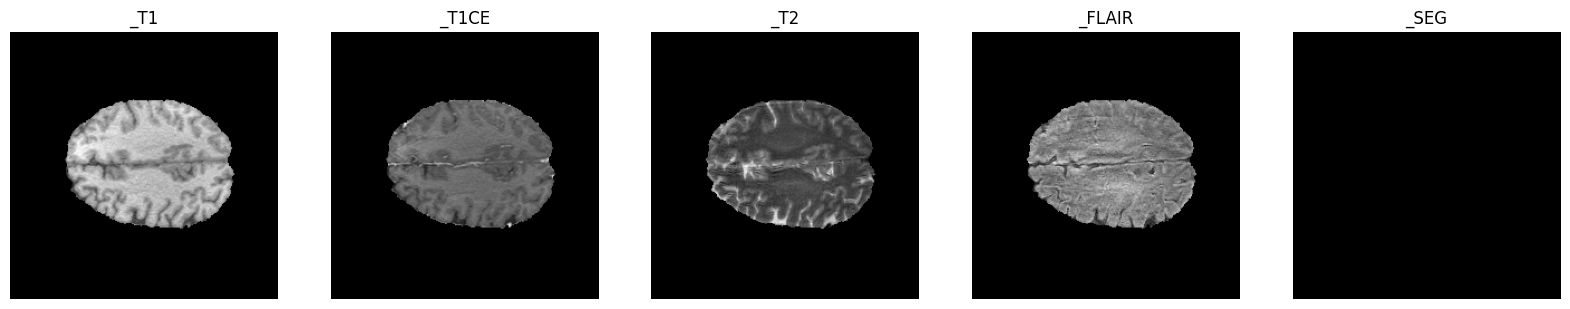

In [ ]:
import nibabel as nib
import matplotlib.pyplot as plt

def load_mri_images(base_path, modalities):
    images = {}
    for modality in modalities:
        img = nib.load(f"{base_path}{modality}.nii")
        images[modality] = img.get_fdata()
    return images

def plot_mri_slices(images, slice_nb):
    fig, axs = plt.subplots(1, len(images), figsize=(20, 20))
    for i, (modality, image_data) in enumerate(images.items()):
        axs[i].imshow(image_data[:,:,slice_nb], cmap="gray")
        axs[i].set_title(modality.upper())
        axs[i].axis('off')
    plt.show()

sample_path = str(current_directory)+'/datasets/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_020/BraTS20_Training_020'
modalities = ['_t1', '_t1ce', '_t2', '_flair', '_seg']

images = load_mri_images(sample_path, modalities)

plot_mri_slices(images, 100)


Trong chụp MRI (Chụp cộng hưởng từ), các loại hình ảnh như T1, T1ce, T2, và FLAIR đều được sử dụng để cung cấp các góc nhìn khác nhau về cấu trúc và bệnh lý của não và các bộ phận khác của cơ thể. Mỗi loại hình ảnh có đặc điểm và ứng dụng riêng:

- T1:
    - Đặc điểm: Trong ảnh MRI loại T1, chất béo xuất hiện với độ sáng cao, trong khi nước và dịch thể xuất hiện tối. Cấu trúc như xương và không khí cũng xuất hiện tối.
    - Ứng dụng: Hình ảnh T1 thường được dùng để đánh giá cấu trúc giải phẫu của não, ví dụ như để xem xét khối u, tổn thương hoặc phẫu thuật.

- T1ce (T1 với chất tương phản):
    - Đặc điểm: Loại hình này là hình ảnh T1 sau khi tiêm chất tương phản (thường là gadolinium). Chất tương phản làm tăng độ sáng của các vùng có sự tăng lưu lượng máu hoặc rò rỉ mạch máu.
    - Ứng dụng: T1ce rất hữu ích trong việc phát hiện và đánh giá các khối u, viêm nhiễm, và các tổn thương khác. Chất tương phản giúp phân biệt các mô khỏe mạnh và mô bệnh lý.

- T2:
    - Đặc điểm: Trong hình ảnh T2, nước và dịch thể xuất hiện sáng, trong khi chất béo thì tối hơn so với T1.
    - Ứng dụng: Hình ảnh T2 giúp nhận diện các tổn thương hoặc bệnh lý có liên quan đến dịch hoặc phù nề, như viêm, xuất huyết, hoặc tổn thương do nước.

- FLAIR (Fluid Attenuated Inversion Recovery):
    - Đặc điểm: Hình ảnh FLAIR là biến thể của hình ảnh T2, nhưng dịch trong não như dịch não tủy được làm mờ đi, giúp các tổn thương hoặc bệnh lý nổi bật hơn.
    - Ứng dụng: Hình ảnh FLAIR đặc biệt hữu ích trong việc phát hiện các vùng có tổn thương do đột quỵ, nhiễm trùng, và các bệnh lý khác mà ở đó có sự dịch chuyển dịch não tủy.

In [ ]:
def print_image_shapes(images):
    for modality, data in images.items():
        print(f"{modality.upper()} shape: {data.shape}")

print_image_shapes(images)

_T1 shape: (240, 240, 155)
_T1CE shape: (240, 240, 155)
_T2 shape: (240, 240, 155)
_FLAIR shape: (240, 240, 155)
_SEG shape: (240, 240, 155)


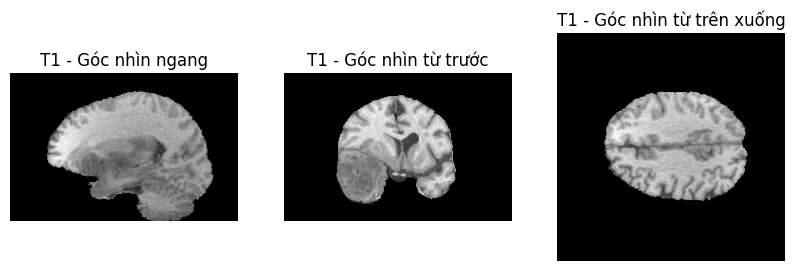

In [ ]:
def plot_mri_planes(data, slice_nb, title_prefix):
    fig, axs = plt.subplots(1, 3, figsize=(10, 10))

    # Sagittal view
    axs[0].imshow(rotate(data[slice_nb, :, :], 90, resize=True), cmap="gray")
    axs[0].set_title(f'{title_prefix} - Góc nhìn ngang')
    axs[0].axis('off')

    # Coronal view
    axs[1].imshow(rotate(data[:, slice_nb, :], 90, resize=True), cmap="gray")
    axs[1].set_title(f'{title_prefix} - Góc nhìn từ trước')
    axs[1].axis('off')

    # Axial view
    axs[2].imshow(data[:, :, slice_nb], cmap="gray")
    axs[2].set_title(f'{title_prefix} - Góc nhìn từ trên xuống')
    axs[2].axis('off')

    plt.show()

plot_mri_planes(images['_t1'], 100, 'T1')


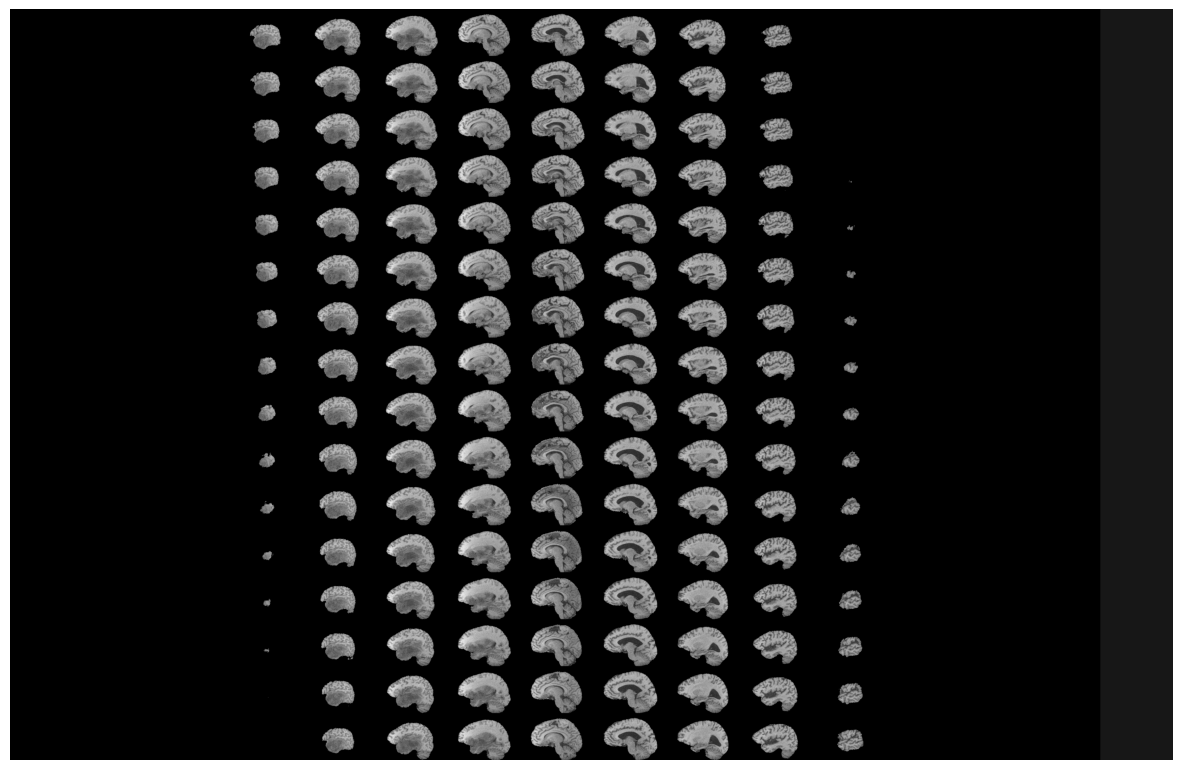

In [ ]:

def plot_rotated_montage(image_data, rotation_angle, resize=True):
    montaged_image = montage(image_data)

    rotated_image = rotate(montaged_image, rotation_angle, resize=resize)

    fig, ax = plt.subplots(figsize=(15, 15))
    ax.imshow(rotated_image, cmap='gray')
    ax.axis('off')
    plt.show()

plot_rotated_montage(images['_t1'], 90)

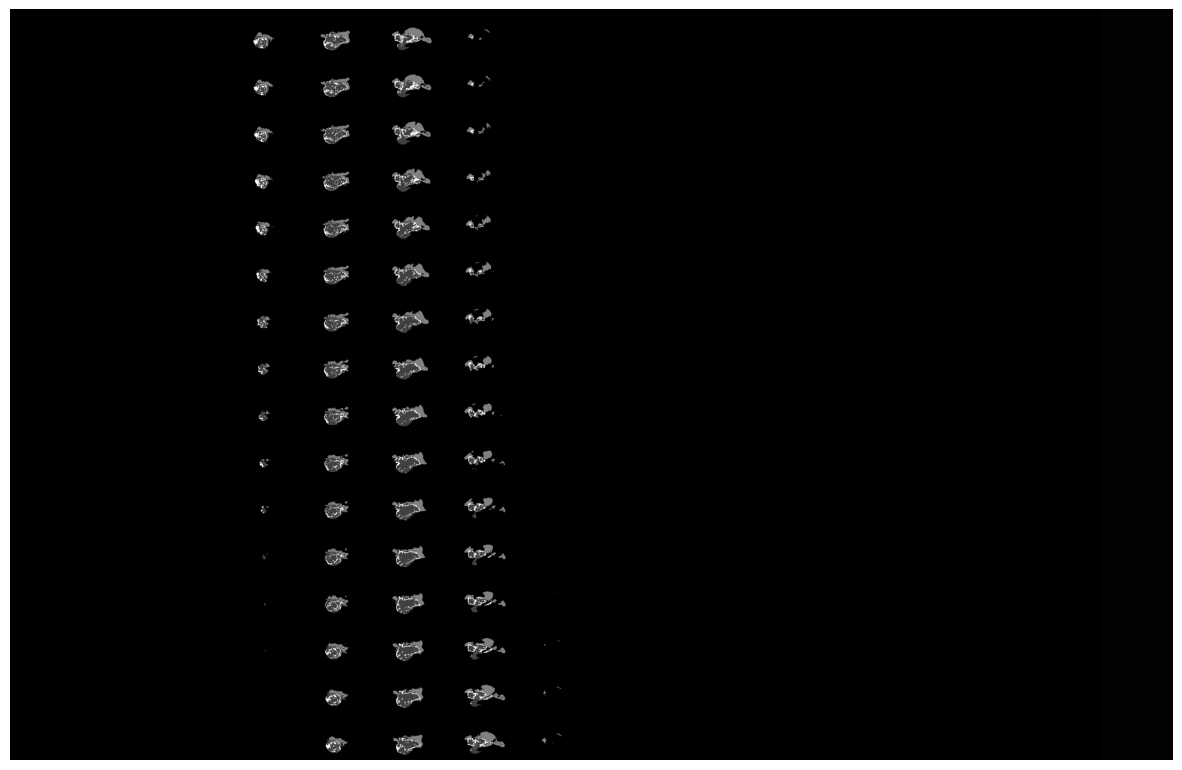

In [ ]:
plot_rotated_montage(images['_seg'], 90)

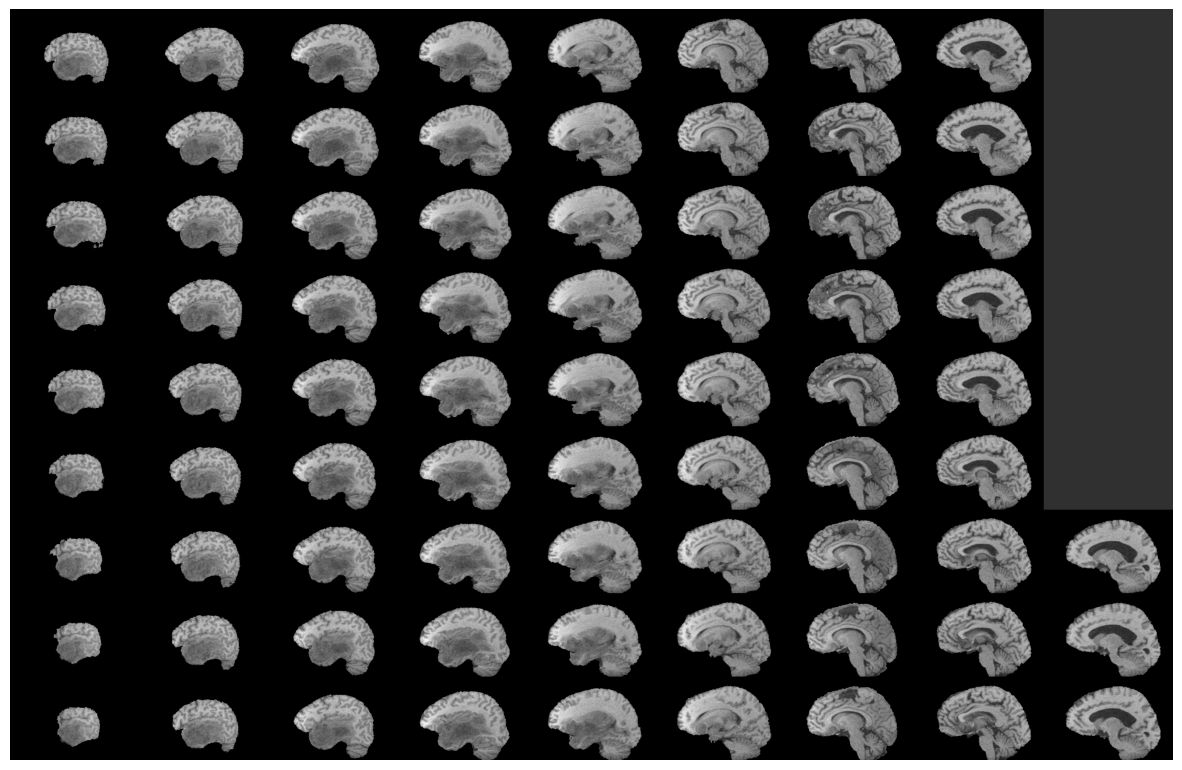

In [ ]:
plot_rotated_montage(images['_t1'][60:135,:,:], 90)

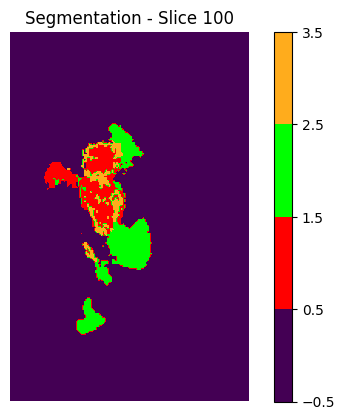

In [ ]:
data_path =  str(current_directory)+'/datasets/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_020/BraTS20_Training_020_seg.nii'
segmentation_data = nib.load(data_path).get_fdata()

colors = ['#440054', '#FF0000', '#00FF00', '#FFAC1C']
cmap = mpl.colors.ListedColormap(colors)
norm = mpl.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

fig, ax = plt.subplots()
im = ax.imshow(segmentation_data[100, :, :], cmap=cmap, norm=norm)
fig.colorbar(im)
ax.set_title("Segmentation - Slice 100")
ax.axis('off')

plt.show()

In [ ]:
def load_segmentation_files(data_path):
    seg_files = [
        os.path.join(data_path, sample, f"{sample}_seg.nii")
        for sample in os.listdir(data_path)
        if not sample.endswith('.csv')
    ]
    return seg_files

def find_max_unique_values(seg_files):
    max_nb_values = 0
    saved_values = []

    for sample in seg_files:
        try:
            seg_img = nib.load(sample).get_fdata()
            unique_values = np.unique(seg_img)
            nb_unique_values = len(unique_values)

            if nb_unique_values > max_nb_values:
                max_nb_values = nb_unique_values
                saved_values = unique_values
        except Exception as e:
            print(f"Failed to load {sample}: {e}")

    return max_nb_values, saved_values

data_path = str(current_directory)+"/datasets/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
seg_files = load_segmentation_files(data_path)
max_values, values = find_max_unique_values(seg_files)

print(f"Các nhãn độc lập trong tập dữ liệu: {max_values}")
print(f"Giá trị của nhãn: {values}")

Failed to load /content/datasets/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_seg.nii: No such file or no access: '/content/datasets/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_seg.nii'
Các nhãn độc lập trong tập dữ liệu: 4
Giá trị của nhãn: [0. 1. 2. 4.]


In [ ]:
def print_unique_counts(image_data):
    values, counts = np.unique(image_data, return_counts=True)
    for value, count in zip(values, counts):
        print(f"Giá trị của nhãn: {value}, Số lượng: {count}")

print_unique_counts(segmentation_data)

Giá trị của nhãn: 0.0, Số lượng: 8752325
Giá trị của nhãn: 1.0, Số lượng: 91299
Giá trị của nhãn: 2.0, Số lượng: 56966
Giá trị của nhãn: 4.0, Số lượng: 27410


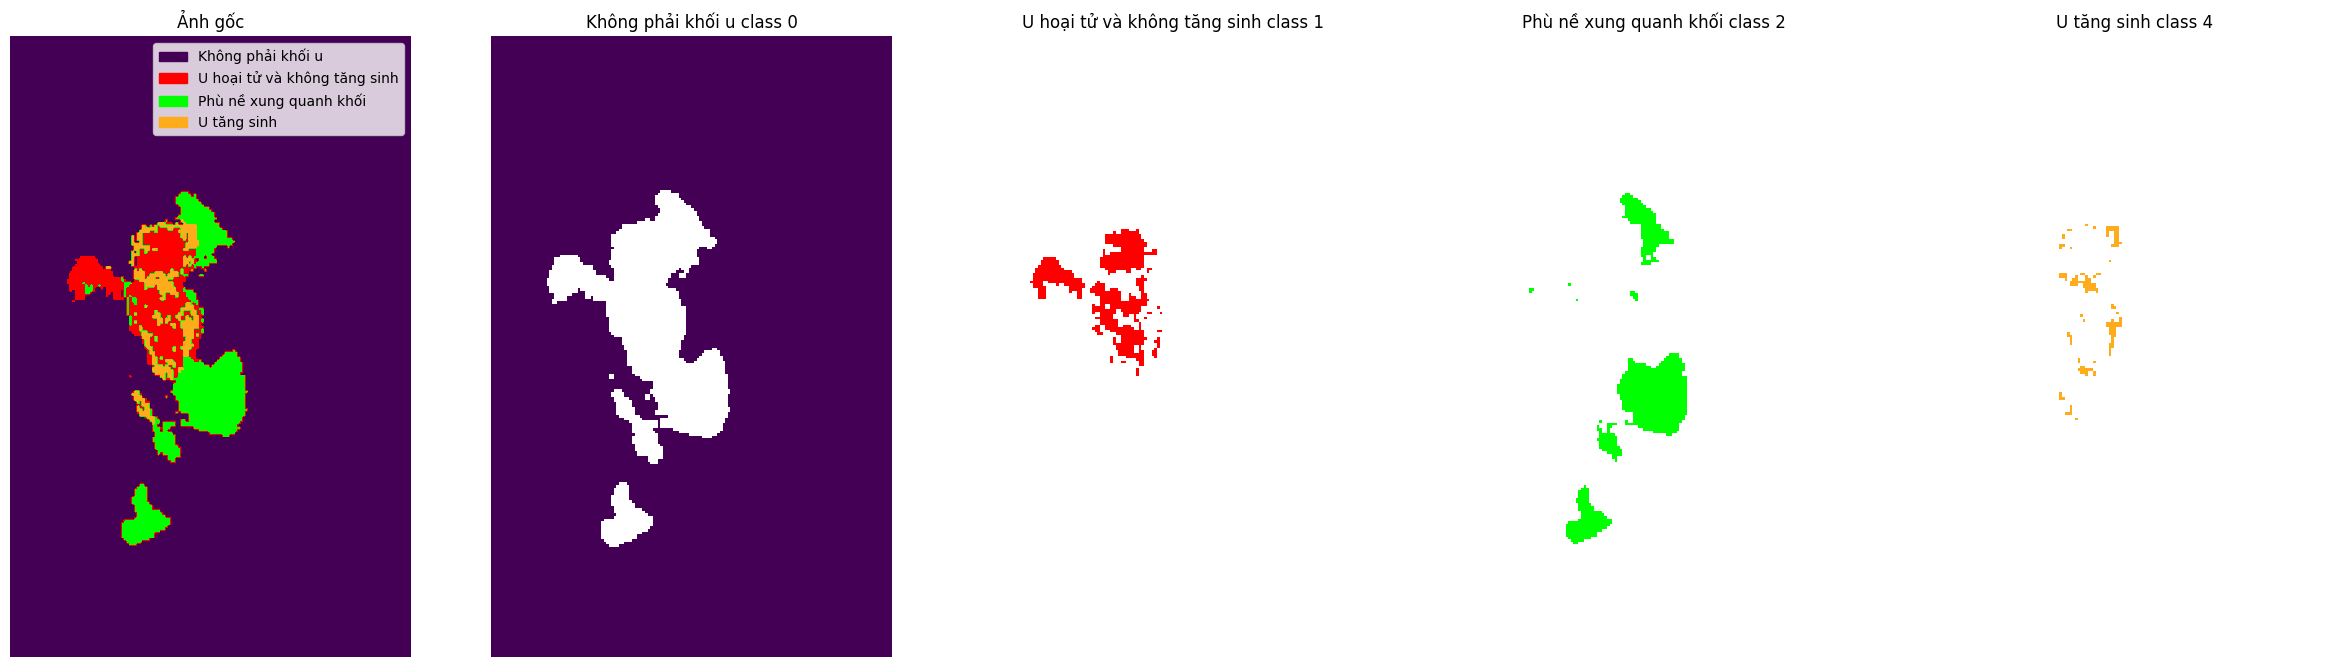

In [ ]:
def isolate_class(image_data, class_label):
    isolated = image_data.copy()
    isolated[isolated != class_label] = np.nan
    return isolated

class_names = ['Không phải khối u', 'U hoại tử và không tăng sinh', 'Phù nề xung quanh khối', 'U tăng sinh']
classes = [0, 1, 2, 4]
segments = [isolate_class(segmentation_data, cls) for cls in classes]

legend = [patches.Rectangle((0, 0), 1, 1, color=cmap(i), label=class_names[i]) for i in range(len(class_names))]

fig, axs = plt.subplots(1, 5, figsize=(30, 15))

titles = ['Ảnh gốc'] + [f'{name} class {cls}' for name, cls in zip(class_names, classes)]
for ax, segment, title in zip(axs, [segmentation_data]+segments, titles):
    ax.imshow(segment[100, :, :], cmap=cmap, norm=norm)
    ax.set_title(title)
    ax.axis('off')

axs[0].legend(handles=legend, loc='upper right')

plt.show()

# Tóm lại quá trình trên cho chúng ta các thông tin như sau:

- Đối với mỗi mẫu/bệnh nhân, chúng ta có 4 loại hình ảnh khác nhau (T1, T1CE, T2 & FLAIR), đi kèm với một hình ảnh phân đoạn chỉ ra các khu vực có khối u.
- Các loại hình T1CE và FLAIR rất đáng để giữ lại, vì hai loại này cung cấp thông tin bổ sung về giải phẫu và độ tương phản của mô não của bệnh nhân.
- Mỗi hình ảnh là 3D, do đó có thể được phân tích qua 3 mặt phẳng khác nhau, mỗi mặt phẳng bao gồm các lát cắt 2D.
- Nhiều lát cắt chứa ít hoặc không có thông tin. Chúng ta chỉ giữ lại khoảng lát cắt (60:135) cho bài này. Cũng như để tăng tốc độ huấn luyện mô hình.
- Một hình ảnh phân đoạn chứa từ 1 đến 4 lớp.



In [ ]:
VOLUME_START_AT = 60
VOLUME_SLICES = 75
DATA_PATH = str(current_directory)+"/datasets/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
EXCLUDED_FILES = ["survival_info.csv", "name_mapping.csv"]
TRAIN_SIZE = 0.85
VAL_SIZE = 0.2
RANDOM_STATE = 42

def load_samples(data_path):
    try:
        samples = os.listdir(data_path)
    except FileNotFoundError:
        print(f"Error: Đường dẫn {data_path} không tồn tại.")
        return []
    except PermissionError:
        print(f"Error: Không có quyền truy cập {data_path}.")
        return []

    samples = [sample for sample in samples if sample not in EXCLUDED_FILES]
    return samples

def split_data(samples):
    samples_train, samples_val = train_test_split(samples, test_size=VAL_SIZE, random_state=RANDOM_STATE)
    samples_train, samples_test = train_test_split(samples_train, test_size=(1 - TRAIN_SIZE), random_state=RANDOM_STATE)

    return samples_train, samples_val, samples_test

def print_distribution(samples_train, samples_val, samples_test):
    print(f"Độ dài tập Train: {len(samples_train)} ({len(samples_train)/len(samples)*100:.2f}%)")
    print(f"Độ dài tập Validation: {len(samples_val)} ({len(samples_val)/len(samples)*100:.2f}%)")
    print(f"Độ dài tập Test: {len(samples_test)} ({len(samples_test)/len(samples)*100:.2f}%)")


samples = load_samples(DATA_PATH)
if samples:
    samples_train, samples_val, samples_test = split_data(samples)
    print(f"Tổng các samples: {len(samples)}")
    print_distribution(samples_train, samples_val, samples_test)


Tổng các samples: 369
Độ dài tập Train: 250 (67.75%)
Độ dài tập Validation: 74 (20.05%)
Độ dài tập Test: 45 (12.20%)


Trong khi huấn luyện chúng ta không thể gửi trực tiếp ảnh(X) và phân đoạn (y) vào mô hình AI vì việc tải tất cả ảnh 3D sẽ làm quá tải bộ nhớ và có thể gây sập hệ thống, dẫn đến lỗi không khớp hình dạng. Do đó, chúng ta cần tiền xử lý ảnh trước khi đưa vào mô hình, và điều này được thực hiện thông qua Data Generator.

Trong Data Generator, với mỗi mẫu, chúng ta sẽ:

- Lấy đường dẫn của ảnh chế độ (T1CE và FLAIR, vì chúng cung cấp thông tin giải phẫu và độ tương phản của mô não).
- Lấy đường dẫn của phân đoạn.
- Tải ảnh chế độ và phân đoạn tương ứng.
- Tạo mảng X chứa các lát cắt đã chọn (từ 60-135) của hai chế độ này.
- Tạo mảng y chứa các lát cắt của phân đoạn

Ngoài ra, chúng ta cũng sẽ thực hiện các bước sau:

- Làm việc trên mặt phẳng Axial, với kích thước hình ảnh là (240x240). Mặc dù sẽ thao tác trên nhiều lát cắt, nhưng điều này không ảnh hưởng nhiều do khả năng hiển thị trên ba mặt phẳng khác nhau.
- Áp dụng mã hóa One-Hot cho mảng y để phân biệt rõ ràng các lớp từ 0 đến 3, biến đổi chúng thành dạng số mà mạng nơ-ron có thể sử dụng mà không gây hiểu lầm rằng một số lớp cao hơn lớp khác.
- Thay đổi kích thước các lát cắt hình ảnh từ (240x240) xuống (128, 128). Lựa chọn này dựa trên sự cân bằng giữa độ phức tạp mô hình, lượng dữ liệu huấn luyện, nguồn lực tính toán và mục tiêu giữ thông tin. Mặc dù kích thước (256, 256) có thể giữ thông tin tốt hơn, nhưng nó sẽ tăng thời gian đào tạo và yêu cầu bộ nhớ nhiều hơn, do đó chúng ta sẽ chọn (128, 128).

In [ ]:
IMG_SIZE = 128

class DataGenerator(Sequence):

    def __init__(self, list_IDs, dim=(IMG_SIZE, IMG_SIZE), batch_size=1, n_channels=2, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.indexes = None
        self.on_epoch_end()

    def __len__(self):
        return len(self.list_IDs) // self.batch_size

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        batch_ids = [self.list_IDs[k] for k in indexes]

        X, Y = self.__data_generation(batch_ids)
        return X, Y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_ids):
        X = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size * VOLUME_SLICES, 240, 240))

        for batch_index, patient_id in enumerate(batch_ids):
            sample_path = os.path.join(data_path, patient_id, patient_id)
            t1ce_path = f"{sample_path}_t1ce.nii"
            flair_path = f"{sample_path}_flair.nii"
            seg_path = f"{sample_path}_seg.nii"

            t1ce = nib.load(t1ce_path).get_fdata()
            flair = nib.load(flair_path).get_fdata()
            seg = nib.load(seg_path).get_fdata()

            for slice_index in range(VOLUME_SLICES):
                X[slice_index + VOLUME_SLICES * batch_index, :, :, 0] = cv2.resize(flair[:, :, slice_index + VOLUME_START_AT], self.dim)
                X[slice_index + VOLUME_SLICES * batch_index, :, :, 1] = cv2.resize(t1ce[:, :, slice_index + VOLUME_START_AT], self.dim)
                y[slice_index + VOLUME_SLICES * batch_index] = seg[:, :, slice_index + VOLUME_START_AT]

        y[y == 4] = 3
        mask = tf.one_hot(y.astype(int), 4)
        Y = tf.image.resize(mask, self.dim)

        return X / np.max(X), Y


training_generator = DataGenerator(samples_train)
valid_generator = DataGenerator(samples_val)
test_generator = DataGenerator(samples_test)


In [ ]:
# Triển khai mô hình U-Net cho BraTS 2019 tham khảo của tác giả Naomi Fridman nhưng có cải tiến thêm 1 lớp, https://naomi-fridman.medium.com/multi-class-image-segmentation-a5cc671e647a
def build_unet_naomi_fridman(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)

    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)

    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)

    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    conv10 = Conv2D(4, 1, activation = 'softmax')(conv)

    return Model(inputs = inputs, outputs = conv10)

Chúng ta sẽ sử dụng độ chính xác (accuracy), đây là một phép đo phổ biến. Tuy nhiên, chỉ số này có thể không quá hiệu quả làm việc với các bộ dữ liệu không cân bằng như BraTS2020, nơi mà lớp Nền chiếm phần lớn. Để giải quyết vấn đề này, chúng ta sẽ sử dụng thêm các chỉ số khác như giao nhau trên hợp (IoU), hệ số Dice, độ chính xác, độ nhạy và độ đặc hiệu.

- **Accuracy**: Đo lường tỷ lệ tổng thể của các điểm ảnh được phân loại chính xác, bao gồm cả điểm ảnh đúng và sai.

- **IoU**: Đo lường sự trùng khớp giữa phân đoạn dự đoán và phân đoạn gốc.

- **Sensitivity**: Đo lường tỷ lệ các điểm ảnh dương tính truth được dự đoán chính xác là dương tính.

- **Precision**: Đo lường tỷ lệ các điểm ảnh dự đoán là dương tính mà thực sự là dương tính.

- **Specificity**: Đo lường tỷ lệ các điểm ảnh âm tính truth được dự đoán chính xác là âm tính.

In [ ]:
def flatten_channels(y, channel_index):
      return K.flatten(y[:,:,:,channel_index])

def calculate_intersection(y_true_f, y_pred_f):
      return K.sum(y_true_f * y_pred_f)

def dice_coef(y_true, y_pred, smooth=1.0):
      class_num = 4
      total_loss = 0
      for i in range(class_num):
          y_true_f = flatten_channels(y_true, i)
          y_pred_f = flatten_channels(y_pred, i)
          intersection = calculate_intersection(y_true_f, y_pred_f)
          loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
          total_loss += loss
      return total_loss / class_num

def precision(y_true, y_pred):
      true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
      predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
      return true_positives / (predicted_positives + K.epsilon())

def sensitivity(y_true, y_pred):
      true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
      possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
      return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [ ]:
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

model = build_unet_naomi_fridman(input_layer, 'he_normal', 0.2)

model.compile(loss="categorical_crossentropy", optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tensorflow.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity] )

In [ ]:
callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),

    keras.callbacks.ModelCheckpoint(filepath = '/content/drive/MyDrive/Colab Notebooks/BraTS2020/model_.{epoch:02d}-{val_loss:.6f}.m5',
                             verbose=1, save_best_only=True, save_weights_only = True),

    CSVLogger('/content/drive/MyDrive/Colab Notebooks/BraTS2020/training.log', separator=',', append=False)
]

In [ ]:
new_training = False
if new_training:
    history = model.fit(training_generator, epochs=40, steps_per_epoch=len(samples_train), callbacks=callbacks, validation_data=valid_generator)
    model.save('/content/drive/MyDrive/Colab Notebooks/BraTS2020/modelhoanchinh/model1')
    # history = history.history
    # joblib.dump(history,'/content/drive/MyDrive/Colab Notebooks/BraTS2020/modelhoanchinh/model01/history01')
else:
    custom_objects = {'dice_coef': dice_coef, 'precision': precision, 'sensitivity': sensitivity, 'specificity': specificity}
    model = load_model('/content/drive/MyDrive/Colab Notebooks/BraTS2020/modelhoanchinh/model1', custom_objects=custom_objects)
    # history = joblib.load('/content/drive/MyDrive/Colab Notebooks/BraTS2020/modelhoanchinh/model01/history01')


In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/BraTS2020/modelhoanchinh/model1.h5', save_format='h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


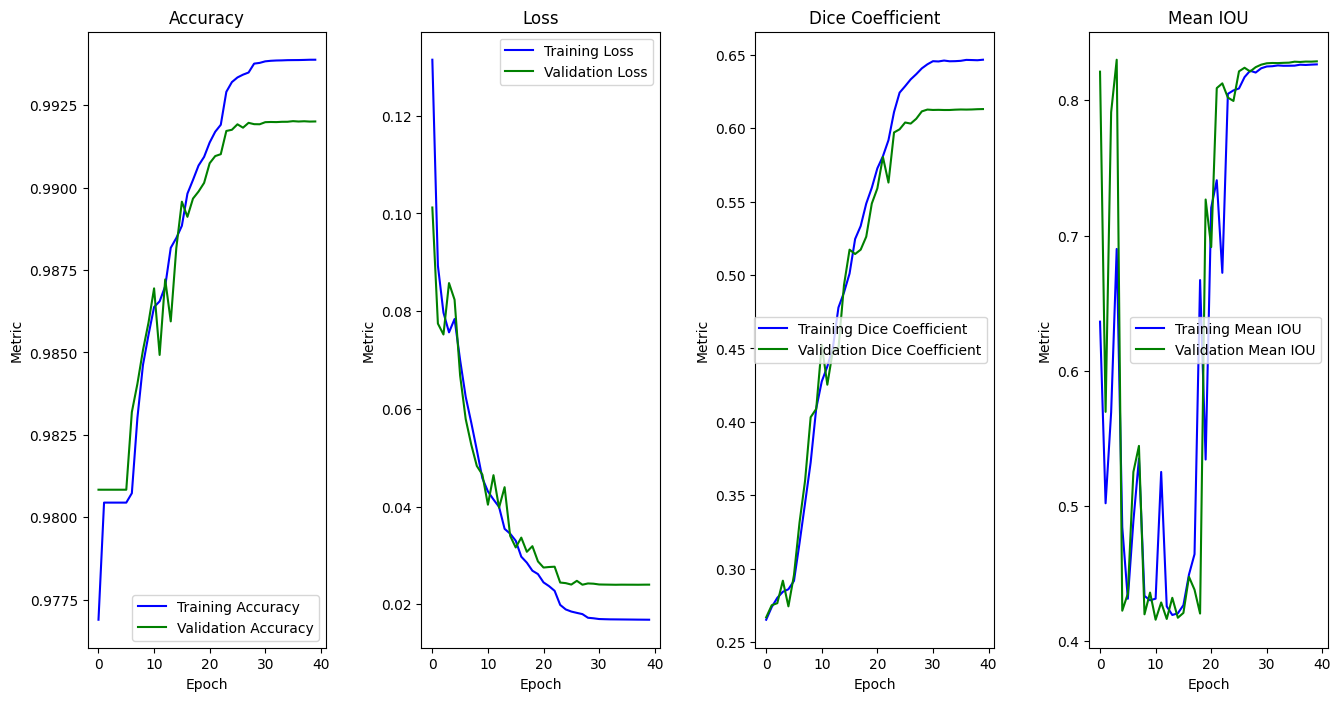

In [ ]:
def plot_metrics(history, metrics, titles, ylabel, legend_loc='best'):
    num_plots = len(metrics)
    fig, axs = plt.subplots(1, num_plots, figsize=(4 * num_plots, 8))

    for ax, metric, title in zip(axs, metrics, titles):
        ax.plot(history['epoch'], history[metric[0]], 'b', label=f'Training {title}')
        ax.plot(history['epoch'], history[metric[1]], 'g', label=f'Validation {title}')
        ax.set_xlabel('Epoch')
        ax.set_ylabel(ylabel)
        ax.set_title(title)
        ax.legend(loc=legend_loc)

    plt.subplots_adjust(wspace=0.4)
    plt.show()

history = pd.read_csv('training.log', sep=',', engine='python')

metrics = [
    ('accuracy', 'val_accuracy'),
    ('loss', 'val_loss'),
    ('dice_coef', 'val_dice_coef'),
    ('mean_io_u', 'val_mean_io_u')
]
titles = ['Accuracy', 'Loss', 'Dice Coefficient', 'Mean IOU']

# Plot the metrics
plot_metrics(history, metrics, titles, 'Metric')


In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU

LEARNING_RATE = 0.001
DROPOUT_RATE = 0.2
WEIGHTS_FILE_PATH = '/content/drive/MyDrive/Colab Notebooks/BraTS2020/modelhoanchinh/model1.h5'

def build_model():
    input_layer = Input((IMG_SIZE, IMG_SIZE, 2))
    model = build_unet_naomi_fridman(input_layer, 'he_normal', DROPOUT_RATE)
    return model

def compile_model(model):
    model.compile(
        loss="categorical_crossentropy",
        optimizer=Adam(learning_rate=LEARNING_RATE),
        metrics=[
            'accuracy',
            MeanIoU(num_classes=4),
            dice_coef,
            precision,
            sensitivity,
            specificity
        ]
    )

last_model = build_model()
compile_model(last_model)
last_model.load_weights(WEIGHTS_FILE_PATH)

In [ ]:

VOLUME_SLICES = 75
VOLUME_START_AT = 60

def load_and_resize_volume(path, slice_index, new_size, volume_start_at):
    volume = nib.load(path).get_fdata()
    resized_volume = np.array([cv2.resize(volume[:,:,i+volume_start_at], new_size) for i in range(slice_index)])
    return resized_volume

def predict_segmentation(sample_path):
    t1ce_path = sample_path + '_t1ce.nii'
    flair_path = sample_path + '_flair.nii'

    flair_resized = load_and_resize_volume(flair_path, VOLUME_SLICES, (IMG_SIZE, IMG_SIZE), VOLUME_START_AT)
    t1ce_resized = load_and_resize_volume(t1ce_path, VOLUME_SLICES, (IMG_SIZE, IMG_SIZE), VOLUME_START_AT)

    X = np.stack((flair_resized, t1ce_resized), axis=-1)

    X_normalized = X / np.max(X)

    return model.predict(X_normalized, verbose=1)

def show_predicted_segmentations(samples_list, slice_to_plot, cmap, norm, model):
    random_sample = random.choice(samples_list)
    random_sample_path = os.path.join(DATA_PATH, random_sample, random_sample)

    predicted_seg = predict_segmentation(random_sample_path)
    seg_path = random_sample_path + '_seg.nii'
    seg = nib.load(seg_path).get_fdata()

    seg_resized = cv2.resize(seg[:,:,slice_to_plot+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

    print("Patient number: ", random_sample)
    fig, axstest = plt.subplots(1, 6, figsize=(25, 20))
    layers = [predicted_seg[slice_to_plot,:,:,1:4],predicted_seg[slice_to_plot,:,:,0],predicted_seg[slice_to_plot,:,:,1],predicted_seg[slice_to_plot,:,:,2],predicted_seg[slice_to_plot,:,:,3]]

    titles = ['Original Segmentation', 'Predicted - All Layers', 'Predicted - Background', 'Predicted - Core', 'Predicted - Edema', 'Predicted - Enhancing']
    for i, ax in enumerate(axstest):
        if i == 0:
            ax.imshow(seg_resized, cmap, norm)
        else:
            ax.imshow(layers[i-1])
        ax.set_title(titles[i])
        ax.axis('off')

    plt.subplots_adjust(wspace=0.8)
    plt.show()



3/3 [==============================] - 0s 79ms/step
Patient number:  BraTS20_Training_345


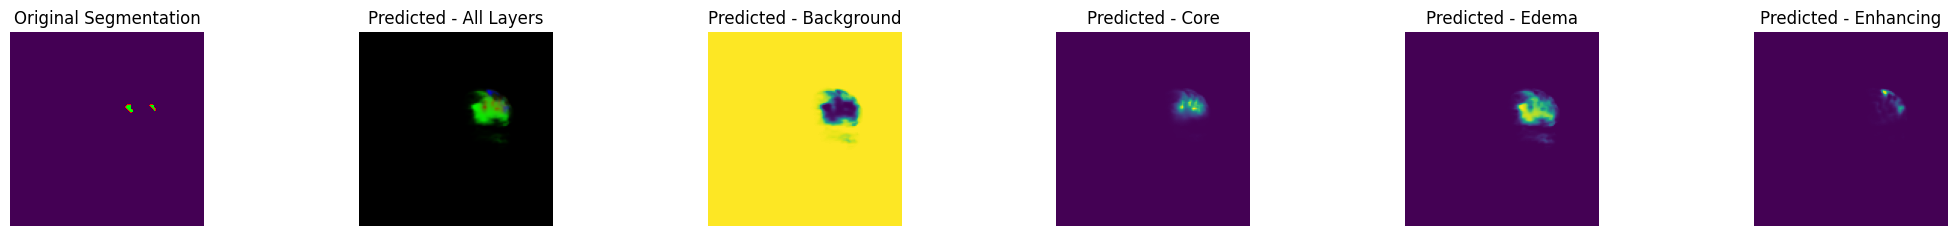

In [ ]:
show_predicted_segmentations(samples_test, 60, cmap, norm, last_model)

3/3 [==============================] - 0s 44ms/step
Patient number:  BraTS20_Training_070


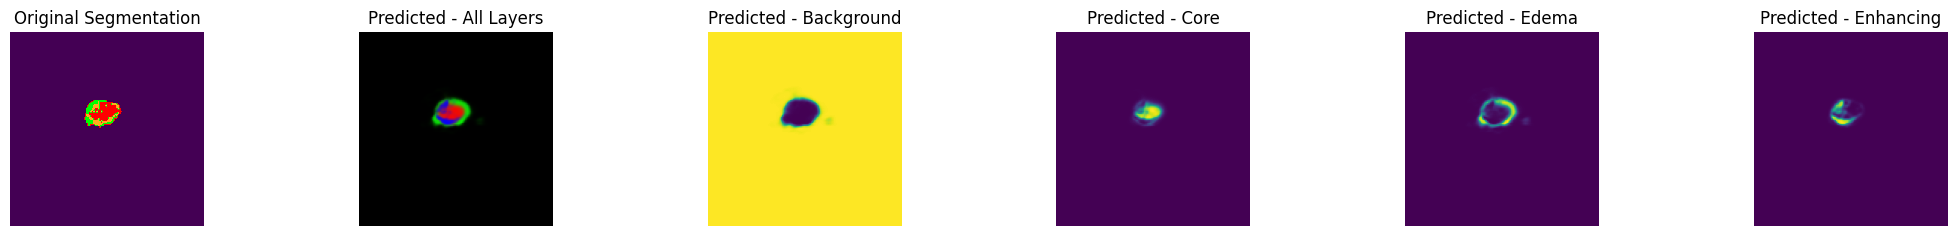

In [ ]:
show_predicted_segmentations(samples_test, 50, cmap, norm, last_model)

3/3 [==============================] - 0s 69ms/step
Patient number:  BraTS20_Training_070


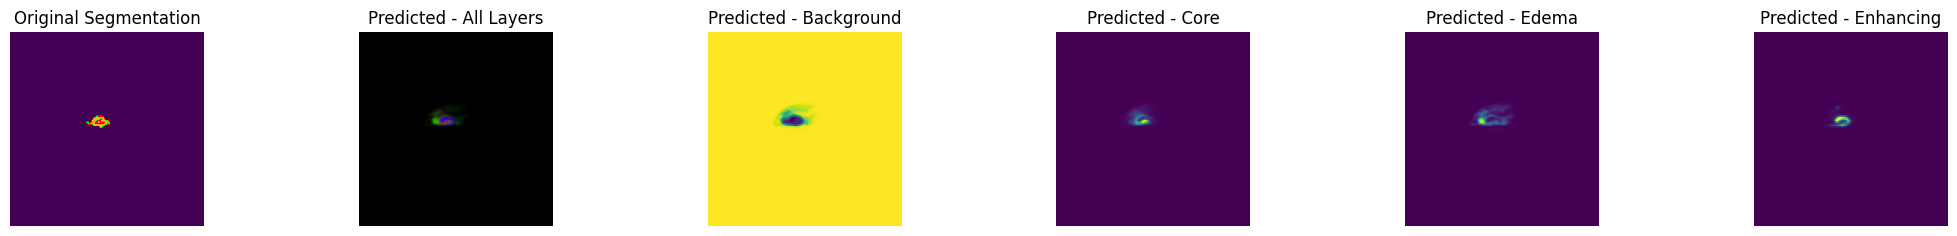

In [ ]:
show_predicted_segmentations(samples_test, 70, cmap, norm, last_model)

3/3 [==============================] - 0s 70ms/step
Patient number:  BraTS20_Training_114


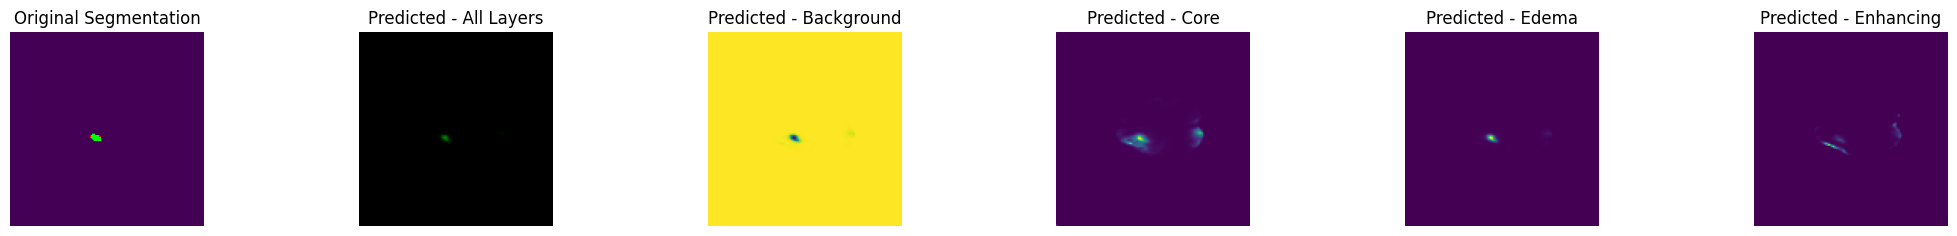

In [ ]:
show_predicted_segmentations(samples_test, 70, cmap, norm, last_model)

3/3 [==============================] - 0s 60ms/step
Patient number:  BraTS20_Training_347


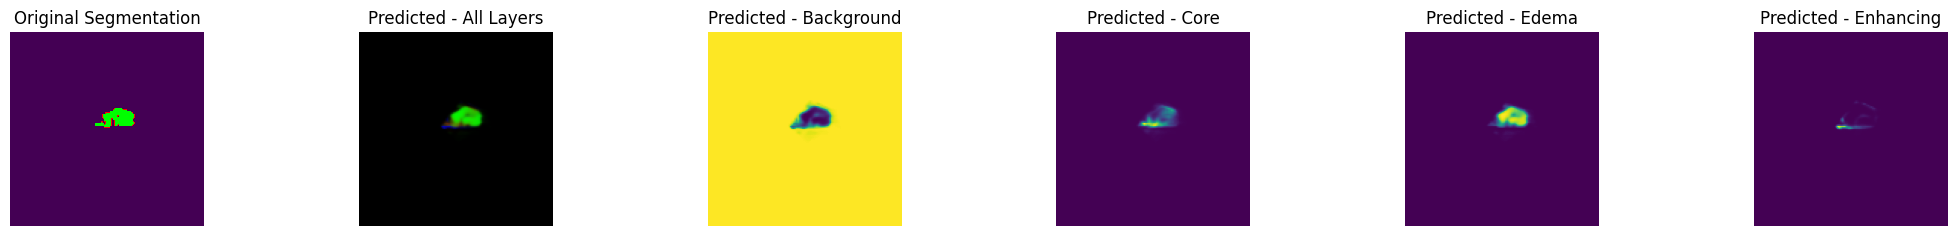

In [ ]:
show_predicted_segmentations(samples_test, 70, cmap, norm, last_model)

In [ ]:
def show_post_processed_segmentations(sample, slice_to_plot, cmap, norm):
    sample_path = os.path.join(data_path, sample, sample)
    seg_path = f"{sample_path}_seg.nii"

    predicted_seg = predict_segmentation(sample_path)
    seg = nib.load(seg_path).get_fdata()

    original_seg = process_original_segmentation(seg, slice_to_plot)
    post_processed_pred = process_predicted_segmentation(predicted_seg, slice_to_plot)
    predicted_wo_postprocessing = predicted_seg[slice_to_plot, :, :, 1:4]

    plot_segmentations(original_seg, predicted_wo_postprocessing, post_processed_pred, cmap, norm, sample)

def process_original_segmentation(seg, slice_to_plot):
    resized_seg = cv2.resize(seg[:, :, slice_to_plot + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
    resized_seg[resized_seg == 4] = 3  # Adjust class labels
    resized_seg = replace_background_with_nan(resized_seg)
    return resized_seg

def process_predicted_segmentation(predicted_seg, slice_to_plot):
    class_indices = np.argmax(predicted_seg, axis=3)
    slice_pred = class_indices[slice_to_plot, :, :].astype(float)
    slice_pred = replace_background_with_nan(slice_pred)
    return slice_pred

def replace_background_with_nan(data):
    data[data == 0] = np.nan
    return data

def plot_segmentations(original_seg, predicted_wo_postprocessing, post_processed_pred, cmap, norm, sample):
    fig, axs = plt.subplots(1, 3, figsize=(15, 10))
    axs[0].imshow(original_seg, cmap, norm)
    axs[0].set_title('Segmentation Gốc')
    axs[1].imshow(predicted_wo_postprocessing)
    axs[1].set_title('Dự đoán không có post processing')
    axs[2].imshow(post_processed_pred, cmap, norm)
    axs[2].set_title('Dự đoán với post processing')
    plt.subplots_adjust(wspace=0.8)
    plt.show()
    print("Bệnh nhân: ", sample)

Kỹ thuật post-processing trong ngành phân tích y tế và xử lý hình ảnh là các bước xử lý được thực hiện sau khi mô hình học máy đã đưa ra dự đoán nhằm cải thiện chất lượng và độ chính xác của kết quả. Trong bối cảnh phân tích y tế, như việc phát hiện khối u, kỹ thuật này đặc biệt quan trọng vì có thể giảm thiểu các dự đoán sai (false positives) và tăng độ chính xác.

Trong bài này chùng ta sẽ sử dụng Argmax Decoding. Kỹ thuật này áp dụng hàm argmax để chọn nhãn cho mỗi pixel dựa trên xác suất cao nhất mà mô hình dự đoán. Điều này giúp chuyển từ dự đoán dựa trên xác suất của từng lớp thành một nhãn cụ thể cho mỗi pixel, làm rõ ràng hơn kết quả phân đoạn.

Việc áp dụng các kỹ thuật post-processing không chỉ giúp cải thiện độ chính xác của dự đoán mà còn giúp giảm thiểu các rủi ro và tác động tiêu cực đến bệnh nhân do những sai sót không cần thiết trong chẩn đoán.

3/3 [==============================] - 0s 76ms/step


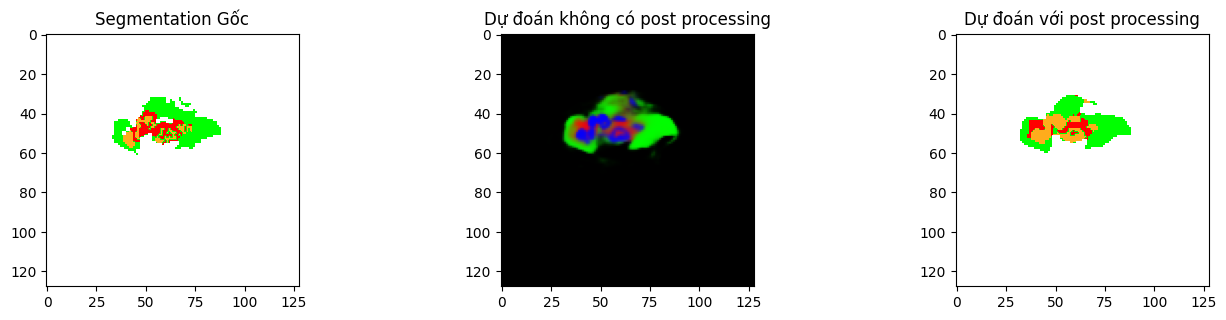

Bệnh nhân:  BraTS20_Training_020


In [ ]:
show_post_processed_segmentations(sample = "BraTS20_Training_020", slice_to_plot=10, cmap=cmap, norm=norm)

3/3 [==============================] - 0s 68ms/step


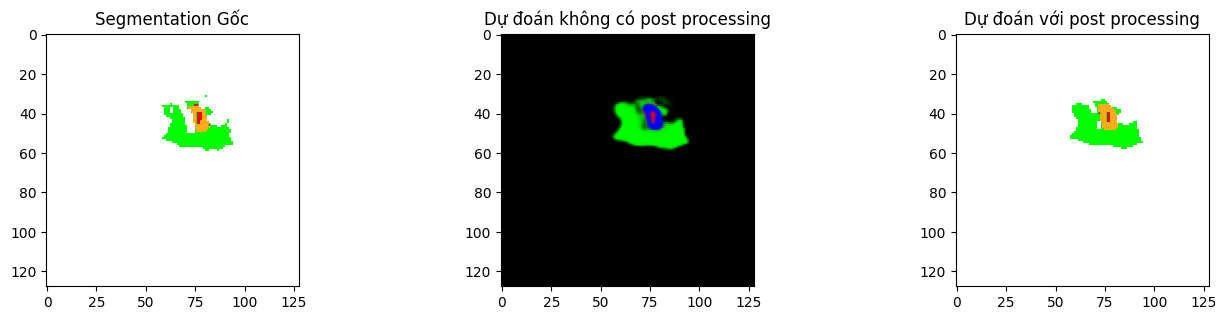

Bệnh nhân:  BraTS20_Training_051


In [ ]:
show_post_processed_segmentations(sample = "BraTS20_Training_051", slice_to_plot=50, cmap=cmap, norm=norm)

3/3 [==============================] - 0s 71ms/step


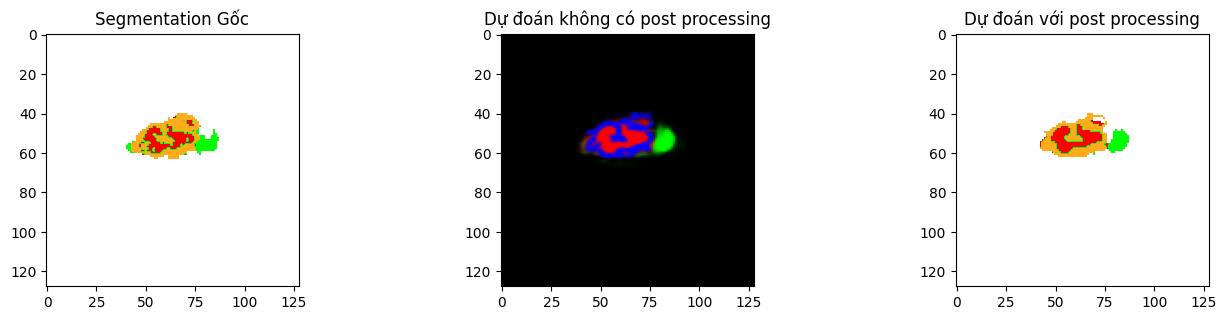

Bệnh nhân:  BraTS20_Training_355


In [ ]:
show_post_processed_segmentations(sample = "BraTS20_Training_355", slice_to_plot=60, cmap=cmap, norm=norm)

3/3 [==============================] - 0s 59ms/step


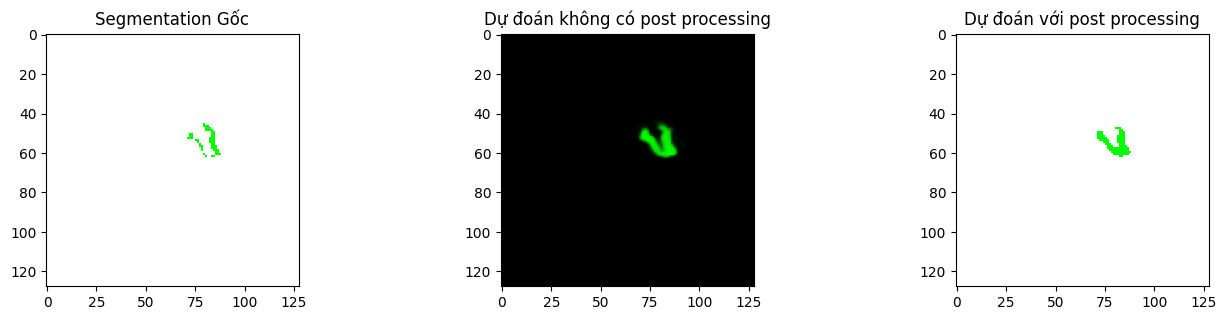

Bệnh nhân:  BraTS20_Training_051


In [ ]:
show_post_processed_segmentations(sample = "BraTS20_Training_051", slice_to_plot=70, cmap=cmap, norm=norm)

3/3 [==============================] - 0s 73ms/step


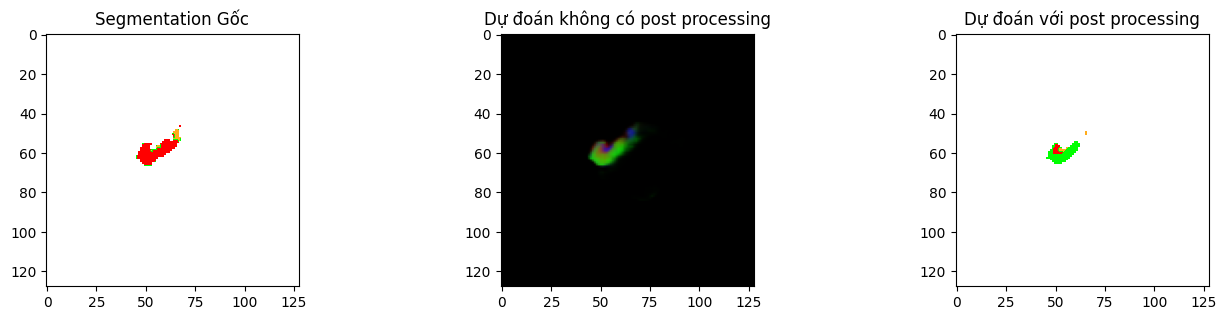

Bệnh nhân:  BraTS20_Training_274


In [ ]:
show_post_processed_segmentations(sample = "BraTS20_Training_274", slice_to_plot=70, cmap=cmap, norm=norm)

In [ ]:
evaluation_results = model.evaluate(test_generator, batch_size=100, callbacks=callbacks)

metric_descriptions = [
    "Loss",
    "Accuracy",
    "MeanIOU",
    "Dice Coefficient",
    "Precision",
    "Sensitivity",
    "Specificity"
]

print("\nKết quả đánh giá model trên tập test:")
print("==================================")
for description, metric in zip(metric_descriptions, evaluation_results):
    print(f"{description}: {metric:.4f}")

45/45 [==============================] - 12s 255ms/step - loss: 0.0197 - accuracy: 0.9932 - mean_io_u: 0.8301 - dice_coef: 0.6376 - precision: 0.9936 - sensitivity: 0.9915 - specificity: 0.9978

Kết quả đánh giá model trên tập test:
Loss: 0.0197
Accuracy: 0.9932
MeanIOU: 0.8301
Dice Coefficient: 0.6376
Precision: 0.9936
Sensitivity: 0.9915
Specificity: 0.9978
